In [1]:
!pip install segmentation-models

In [2]:
# Import Libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.util import view_as_blocks
from skimage import io
from skimage import img_as_ubyte
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="skimage")


import albumentations as A

import tensorflow as tf
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-25 10:54:41.593567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748170481.616195     391 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748170481.623132     391 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


# Exploring the Dataset

Training Image Shape: (165, 768, 1024)
Training Mask Shape: (165, 768, 1024)
Testing Image Shape: (165, 768, 1024)
Testing Mask Shape: (165, 768, 1024)


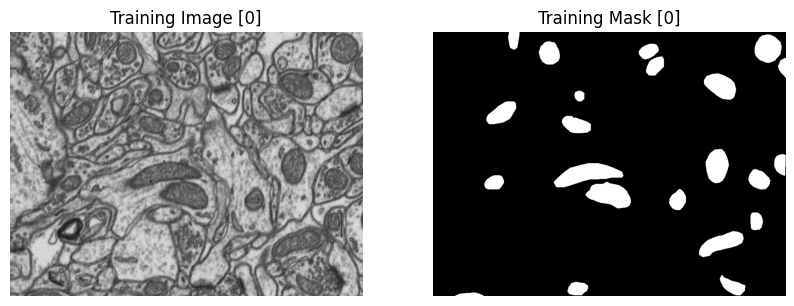

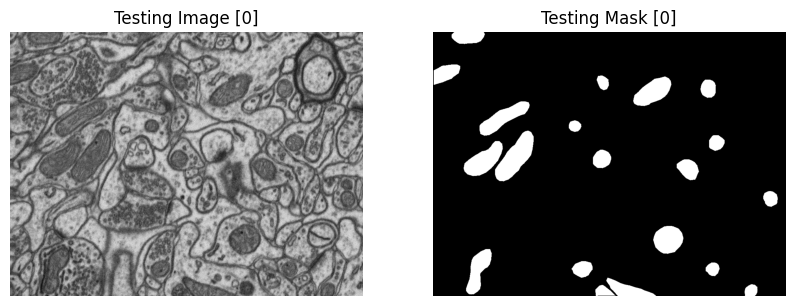

In [3]:
# =======================
# Load Training Data
# =======================
train_img = io.imread('/kaggle/input/mitochondria/training.tif')
train_mask = io.imread('/kaggle/input/mitochondria/training_groundtruth.tif')

print("Training Image Shape:", train_img.shape)
print("Training Mask Shape:", train_mask.shape)

# =======================
# Load Testing Data
# =======================
test_img = io.imread('/kaggle/input/mitochondria/testing.tif')
test_mask = io.imread('/kaggle/input/mitochondria/testing_groundtruth.tif')

print("Testing Image Shape:", test_img.shape)
print("Testing Mask Shape:", test_mask.shape)

# =======================
# Visualize Training Sample
# =======================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Training Image [0]")
plt.imshow(train_img[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Training Mask [0]")
plt.imshow(train_mask[0], cmap='gray')
plt.axis('off')
plt.show()

# =======================
# Visualize Testing Sample
# =======================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Testing Image [0]")
plt.imshow(test_img[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Testing Mask [0]")
plt.imshow(test_mask[0], cmap='gray')
plt.axis('off')
plt.show()

# Creating the Balanced Datasets

In [4]:
# Merge training and testing datasets
all_images = np.concatenate((train_img, test_img), axis=0)   # shape (330, 768, 1024)
all_masks  = np.concatenate((train_mask, test_mask), axis=0) # shape (330, 768, 1024)

print("Merged images shape:", all_images.shape)
print("Merged masks shape:", all_masks.shape)

# Split merged data into Train (70%) and Temp (30%) first
img_train, img_temp, msk_train, msk_temp = train_test_split(
    all_images, all_masks, test_size=0.30, random_state=42, shuffle=True)

# Split Temp into Validation (15%) and Test (15%)
# Since temp is 30%, splitting 2/3 of it for validation gives 20% total
img_val, img_test, msk_val, msk_test = train_test_split(
    img_temp, msk_temp, test_size=1/3, random_state=42, shuffle=True)

# Print final shapes
print("Train set shape:", img_train.shape, msk_train.shape)
print("Validation set shape:", img_val.shape, msk_val.shape)
print("Test set shape:", img_test.shape, msk_test.shape)

Merged images shape: (330, 768, 1024)
Merged masks shape: (330, 768, 1024)
Train set shape: (231, 768, 1024) (231, 768, 1024)
Validation set shape: (66, 768, 1024) (66, 768, 1024)
Test set shape: (33, 768, 1024) (33, 768, 1024)


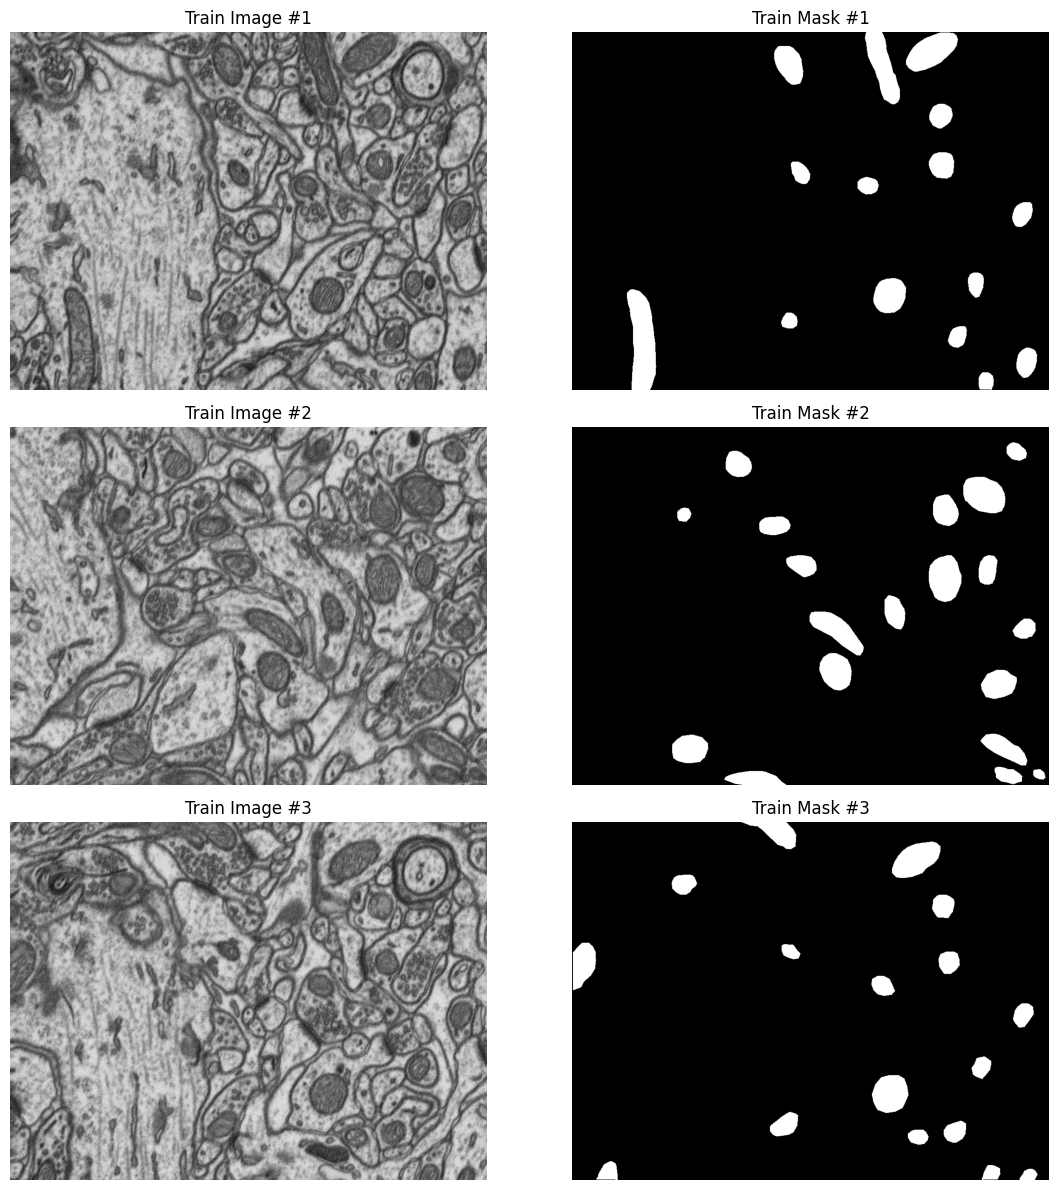

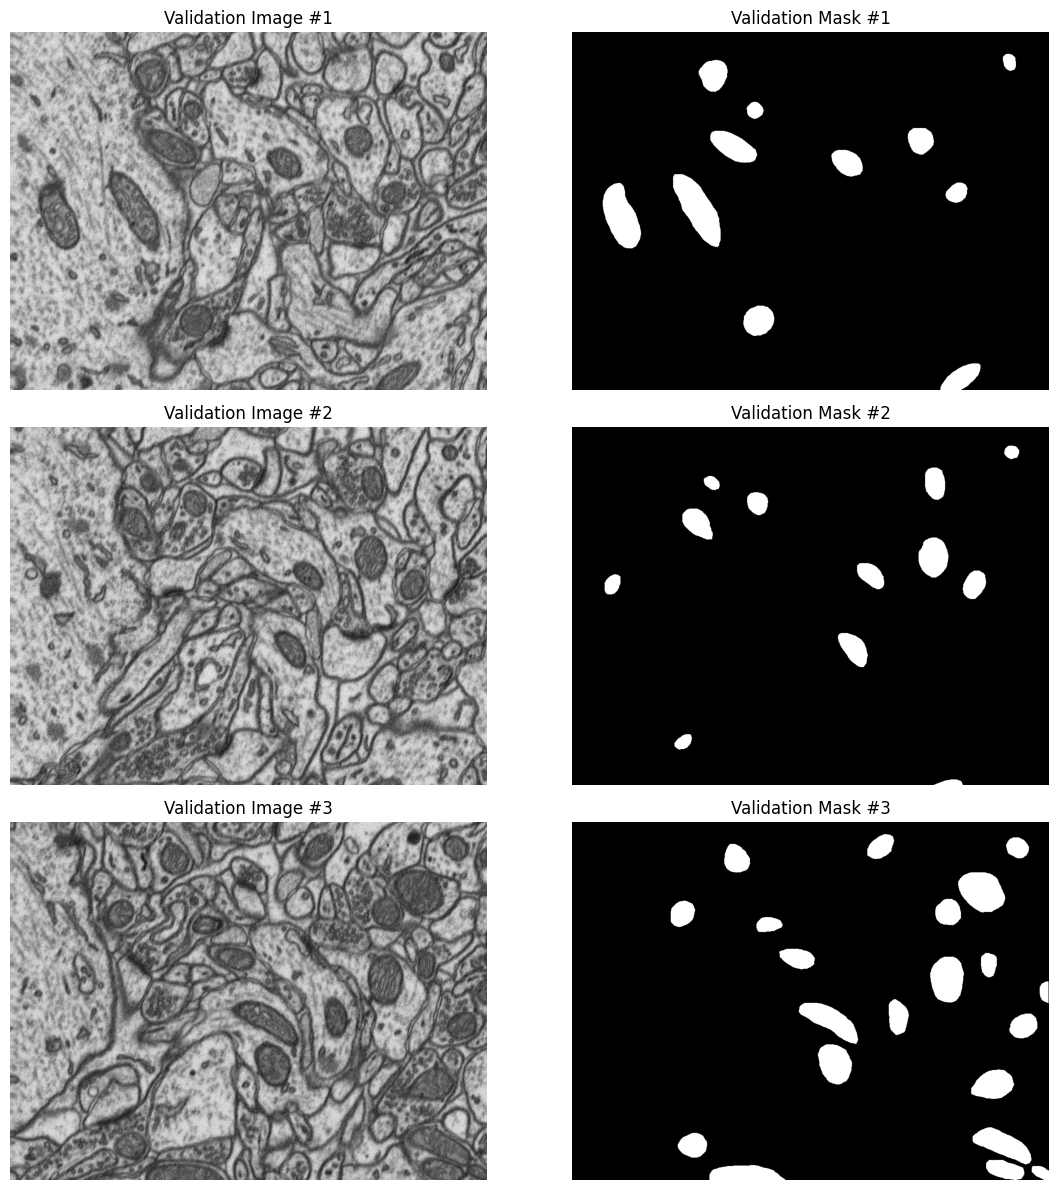

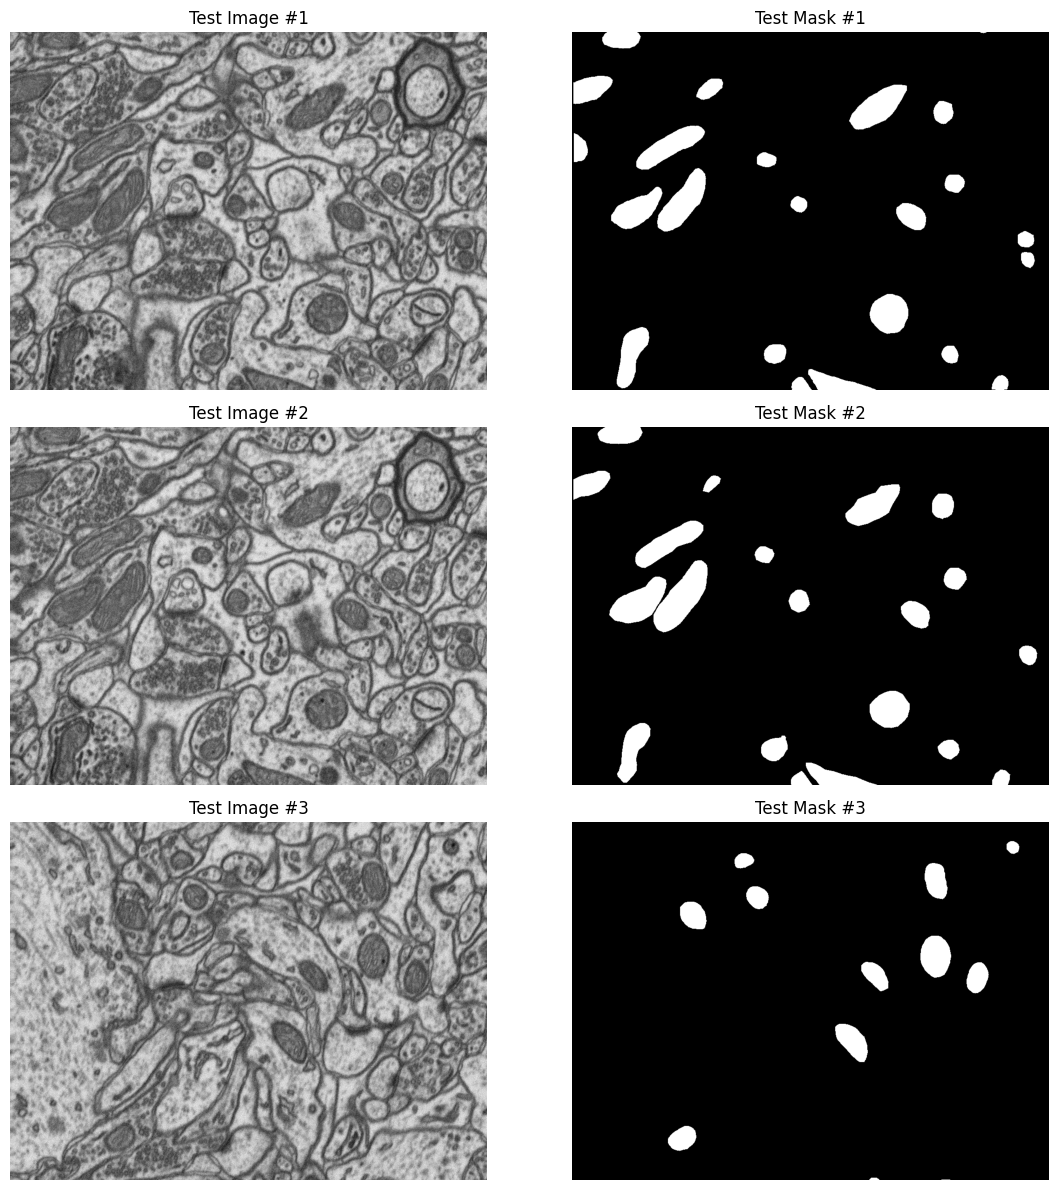

In [5]:
# Visualization function to plot samples
def visualize_samples(images, masks, dataset_name, n_samples=3):
    plt.figure(figsize=(12, 4 * n_samples))
    for i in range(n_samples):
        plt.subplot(n_samples, 2, 2*i + 1)
        plt.title(f"{dataset_name} Image #{i+1}")
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

        plt.subplot(n_samples, 2, 2*i + 2)
        plt.title(f"{dataset_name} Mask #{i+1}")
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize few samples from Train, Validation, and Test
visualize_samples(img_train, msk_train, "Train")
visualize_samples(img_val, msk_val, "Validation")
visualize_samples(img_test, msk_test, "Test")

# Creating Patches of Size 256X256

In [6]:
# ===============================
# Define patch size and helper function
# ===============================
patch_size = 256

def extract_patches(img_set, msk_set, dataset_name=""):
    """
    Extract 256x256 patches from a given image and mask set.
    Returns two numpy arrays: image_patches, mask_patches
    """
    image_patch_list = []
    mask_patch_list = []

    # ===============================
    # Loop over each image and mask in the set
    # ===============================
    for img, msk in zip(img_set, msk_set):
        
        # ===============================
        # Ensure image and mask have 1 channel (grayscale)
        # Add channel dimension if missing (H, W) → (H, W, 1)
        # ===============================
        if img.ndim == 2:
            img = img[..., np.newaxis]
        if msk.ndim == 2:
            msk = msk[..., np.newaxis]

        # ===============================
        # Check if image dimensions are divisible by patch size
        # ===============================
        h, w = img.shape[:2]
        if h % patch_size != 0 or w % patch_size != 0:
            continue  # Skip or add resize/pad logic here if needed

        # ===============================
        # Extract patches from image and mask
        # ===============================
        img_blocks = view_as_blocks(img, block_shape=(patch_size, patch_size, 1))
        msk_blocks = view_as_blocks(msk, block_shape=(patch_size, patch_size, 1))

        # ===============================
        # Flatten grid into list
        # ===============================
        for i in range(img_blocks.shape[0]):
            for j in range(img_blocks.shape[1]):
                image_patch_list.append(img_blocks[i, j, 0])
                mask_patch_list.append(msk_blocks[i, j, 0])

    # ===============================
    # Convert to NumPy arrays
    # ===============================
    image_patch_array = np.array(image_patch_list)
    mask_patch_array = np.array(mask_patch_list)

    print(f"{dataset_name} patches extracted: {len(image_patch_array)}")
    print(f"{dataset_name} Image patch shape: {image_patch_array.shape}")
    print(f"{dataset_name} Mask patch shape:  {mask_patch_array.shape}")
    
    return image_patch_array, mask_patch_array

# ===============================
# Extract patches for each dataset split
# ===============================
train_img_patches, train_mask_patches = extract_patches(img_train, msk_train, "Train")
val_img_patches, val_mask_patches     = extract_patches(img_val, msk_val, "Validation")
test_img_patches, test_mask_patches   = extract_patches(img_test, msk_test, "Test")

Train patches extracted: 2772
Train Image patch shape: (2772, 256, 256, 1)
Train Mask patch shape:  (2772, 256, 256, 1)
Validation patches extracted: 792
Validation Image patch shape: (792, 256, 256, 1)
Validation Mask patch shape:  (792, 256, 256, 1)
Test patches extracted: 396
Test Image patch shape: (396, 256, 256, 1)
Test Mask patch shape:  (396, 256, 256, 1)


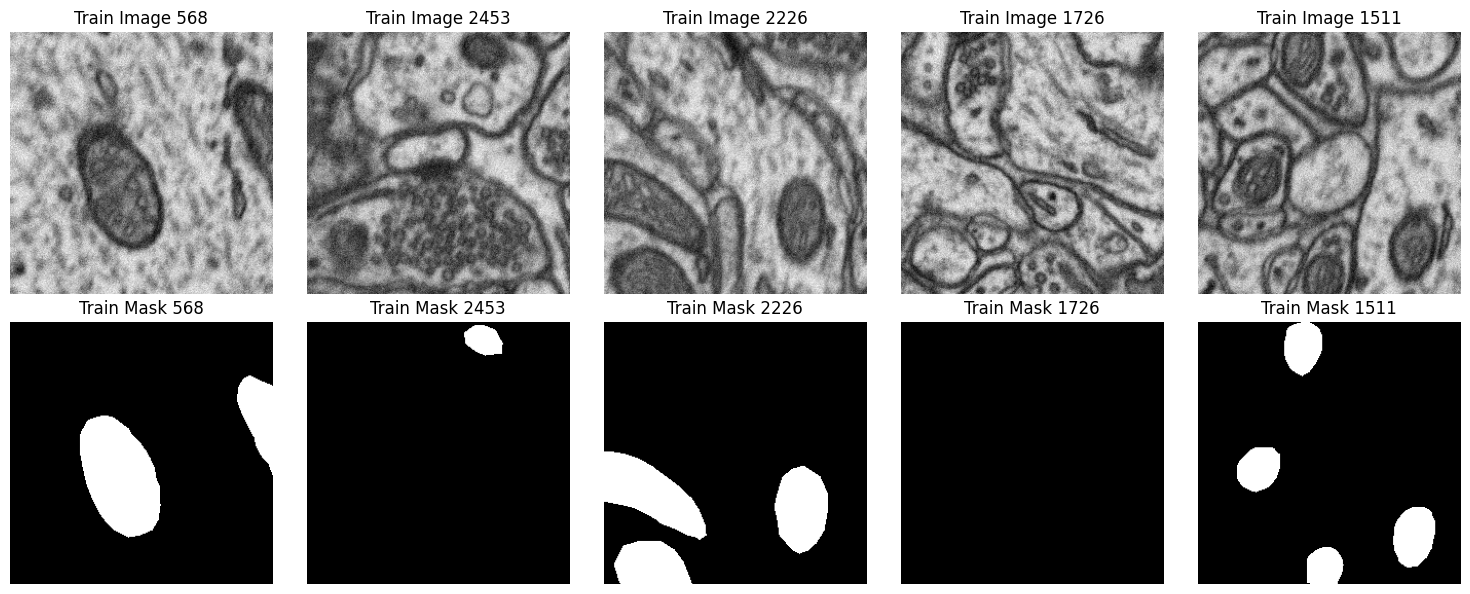

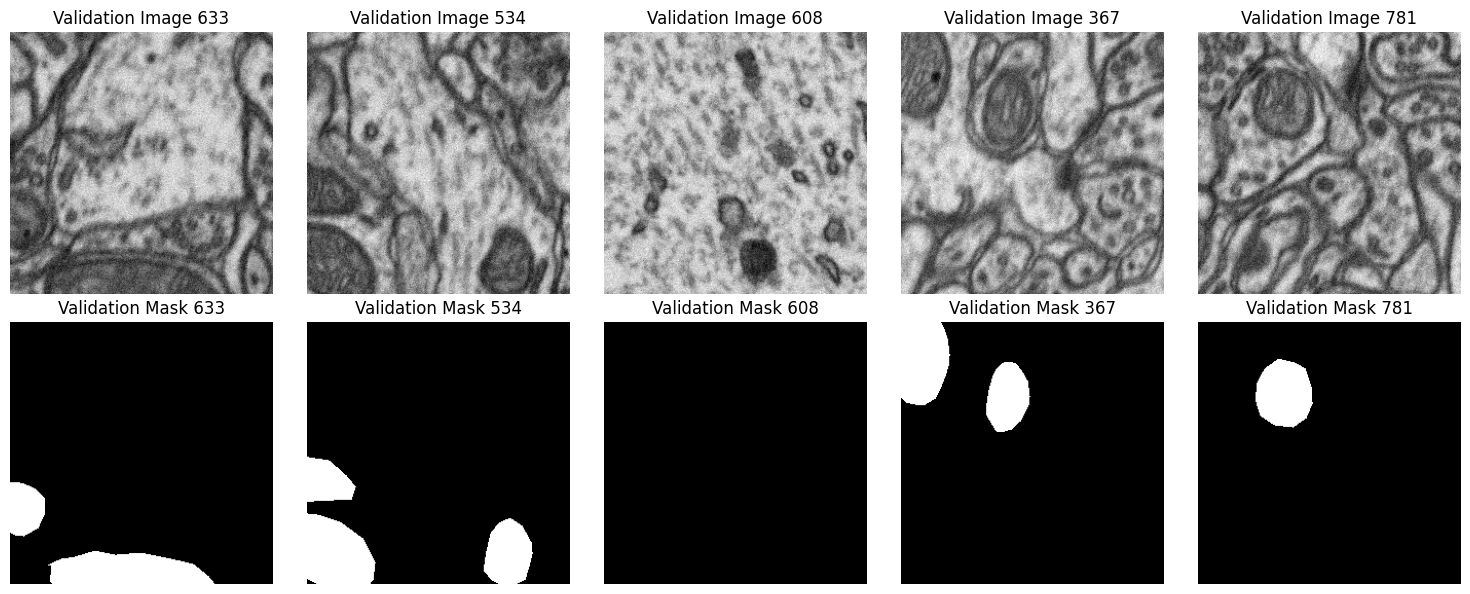

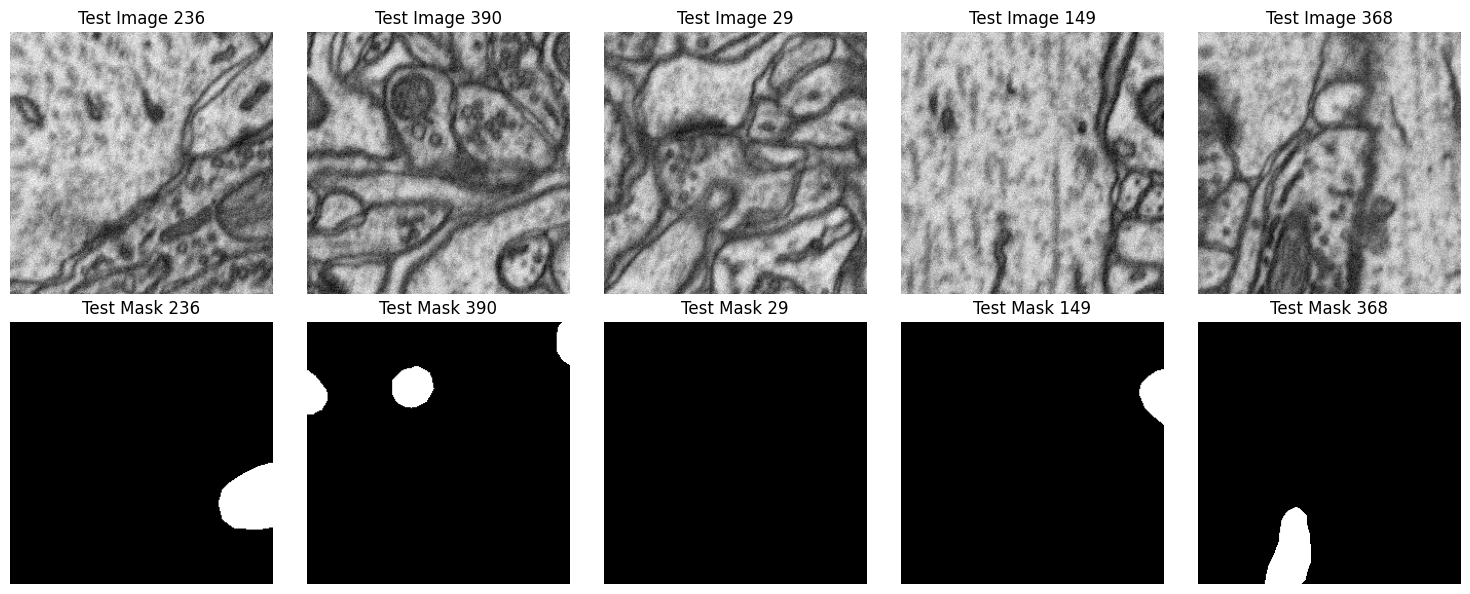

In [7]:
def show_sample_patches(images, masks, title="Dataset", n=5):
    """
    Display n random image-mask pairs from a given dataset.
    """
    indices = random.sample(range(len(images)), n)

    plt.figure(figsize=(n * 3, 6))
    for i, idx in enumerate(indices):
        # Show image
        plt.subplot(2, n, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"{title} Image {idx}")
        plt.axis('off')

        # Show mask
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(masks[idx], cmap='gray')
        plt.title(f"{title} Mask {idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# ===============================
# Visualize 5 random patches from each dataset
# ===============================
show_sample_patches(train_img_patches, train_mask_patches, title="Train", n=5)
show_sample_patches(val_img_patches, val_mask_patches, title="Validation", n=5)
show_sample_patches(test_img_patches, test_mask_patches, title="Test", n=5)

# Augumenting the Dataset

In [8]:
# # ===============================
# # Configuration
# # ===============================

# images_to_generate = 2000  # Number of augmented samples
# augmented_images_path = "/kaggle/working/aug_img/"
# augmented_masks_path  = "/kaggle/working/aug_mask/"

# # Create output directories if they don't exist
# os.makedirs(augmented_images_path, exist_ok=True)
# os.makedirs(augmented_masks_path, exist_ok=True)

# # ===============================
# # Save original patches first
# # ===============================
# print("Saving original training patches...")
# for i, (img, msk) in enumerate(zip(train_img_patches, train_mask_patches), 1):
#     img_to_save = np.squeeze(img)  # Remove channel dim if exists
#     msk_to_save = np.squeeze(msk)
    
#     io.imsave(os.path.join(augmented_images_path, f"image_{i}.png"), img_as_ubyte(img_to_save))
#     io.imsave(os.path.join(augmented_masks_path,  f"mask_{i}.png"), img_as_ubyte(msk_to_save))

# print(f"Saved {i} original patches.")

# # ===============================
# # Define Albumentations Augmentation Pipeline
# # ===============================
# augmentation = A.Compose([
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.HorizontalFlip(p=1.0),
#     A.Transpose(p=1.0),
#     A.GridDistortion(p=1.0),
# ])

# # ===============================
# # Apply Augmentation on In-Memory Patches
# # ===============================
# print(f"Generating {images_to_generate} augmented image-mask pairs from memory...")

# for i in range(1, images_to_generate + 1):
#     idx = random.randint(0, len(train_img_patches) - 1)
#     image = train_img_patches[idx]
#     mask  = train_mask_patches[idx]

#     print(f"[{i}/{images_to_generate}] Augmenting in-memory patch {idx}")

#     augmented = augmentation(image=image, mask=mask)
#     aug_image = augmented['image']
#     aug_mask  = augmented['mask']

#     # Remove singleton channel if present
#     if aug_image.ndim == 3 and aug_image.shape[-1] == 1:
#         aug_image = np.squeeze(aug_image, axis=-1)
#     if aug_mask.ndim == 3 and aug_mask.shape[-1] == 1:
#         aug_mask = np.squeeze(aug_mask, axis=-1)

#     # Save to disk
#     io.imsave(os.path.join(augmented_images_path, f"augmented_image_{i}.png"), img_as_ubyte(aug_image))
#     io.imsave(os.path.join(augmented_masks_path,  f"augmented_mask_{i}.png"), img_as_ubyte(aug_mask))

# print("Augmentation Complete!")

In [9]:
import shutil

# Define the directory you want to zip and output zip file name
source_dir = "/kaggle/working/"
output_zip = "augmented_membrane_data.zip"

# Create a ZIP archive
shutil.make_archive("augmented_membrane_data", 'zip', source_dir)

print("Zipping complete. File saved as:", output_zip)

Zipping complete. File saved as: augmented_membrane_data.zip


In [10]:
# paths_to_remove = [
#     "/kaggle/working/aug_img",
#     "/kaggle/working/aug_mask",
#     "/kaggle/working/augmented_membrane_data.zip"
# ]

# for path in paths_to_remove:
#     if os.path.isdir(path):
#         shutil.rmtree(path)
#         print(f"Deleted folder: {path}")
#     elif os.path.isfile(path):
#         os.remove(path)
#         print(f"Deleted file: {path}")
#     else:
#         print(f"Path not found, skipping: {path}")

# Viz Aug dataset

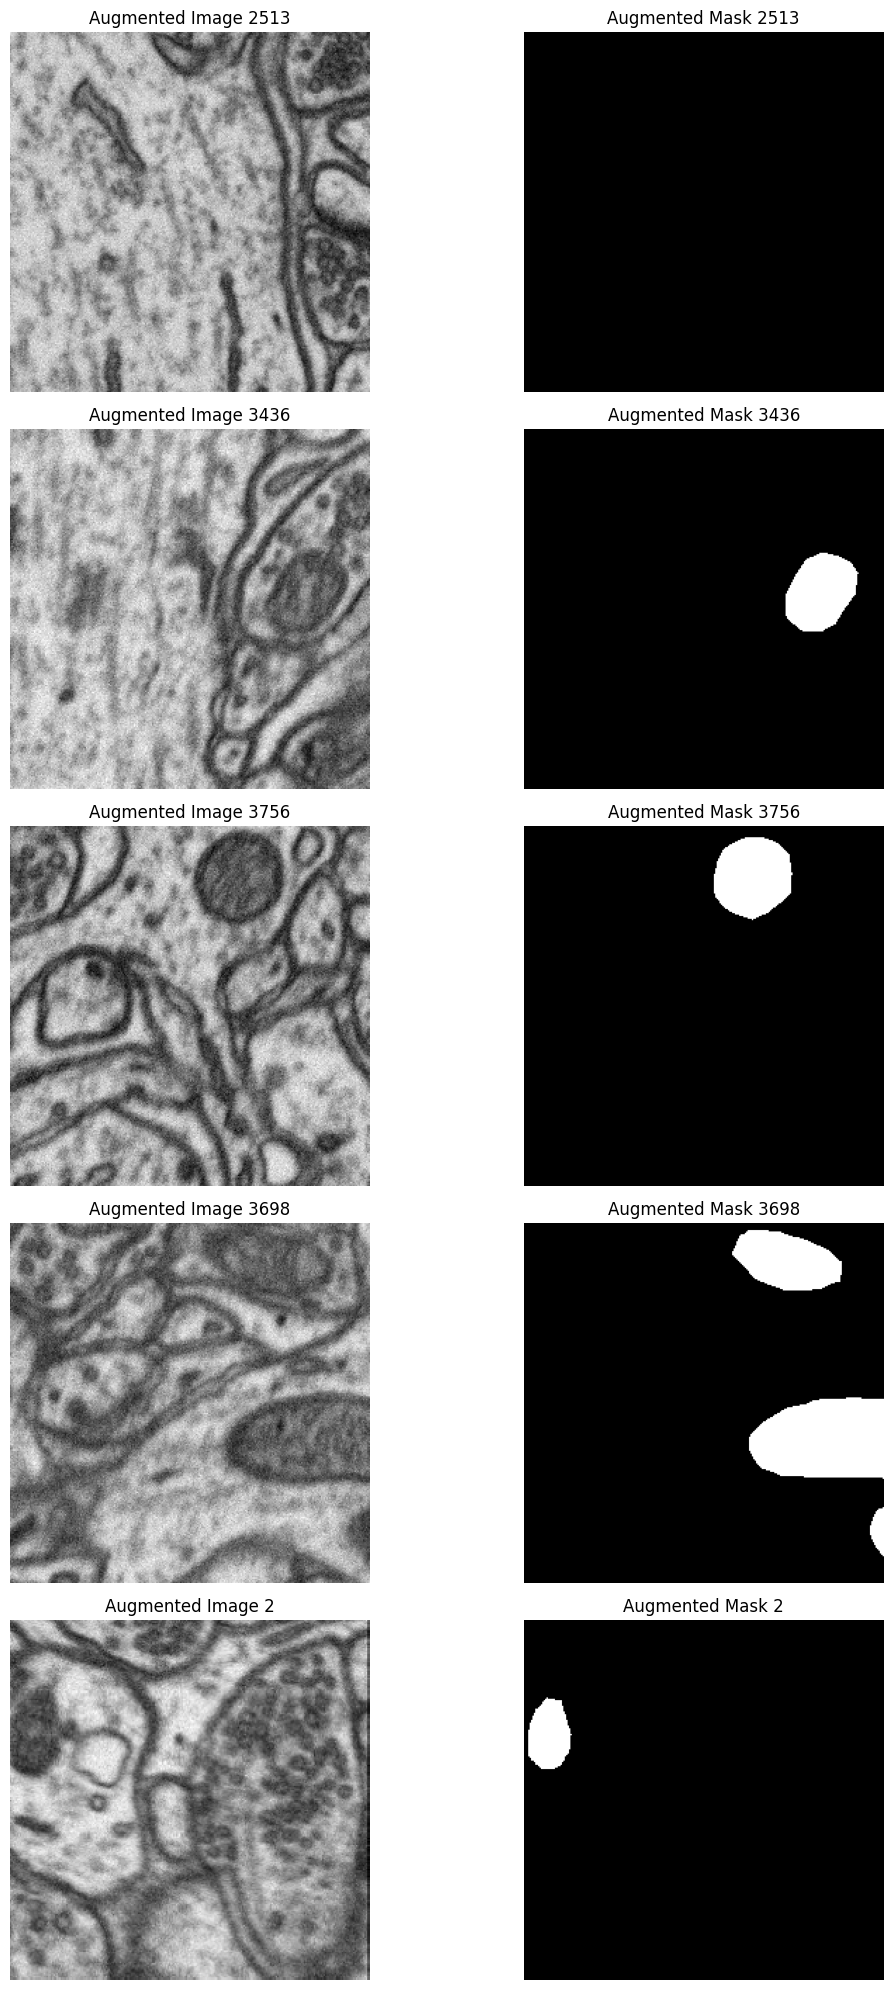

In [11]:
# Paths to augmented images and masks
augmented_images_path = "/kaggle/input/mitco-train-aug/mico_aug/aug_img/"
augmented_masks_path = "/kaggle/input/mitco-train-aug/mico_aug/aug_mask/"

# Get sorted list of image and mask files
image_files = sorted([f for f in os.listdir(augmented_images_path) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(augmented_masks_path) if f.endswith('.png')])

# Number of samples to visualize
num_samples = 5

# Randomly choose indices
sample_indices = random.sample(range(len(image_files)), num_samples)

plt.figure(figsize=(12, num_samples * 4))

for i, idx in enumerate(sample_indices):
    # Load image and mask
    img = io.imread(os.path.join(augmented_images_path, image_files[idx]))
    mask = io.imread(os.path.join(augmented_masks_path, mask_files[idx]))
    
    # Plot image
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Augmented Image {idx+1}")
    plt.axis('off')
    
    # Plot mask
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Augmented Mask {idx+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Lists to hold loaded images and masks
img_list = []
msk_list = []

# Load images and masks, ensure single channel (H, W, 1)
for img_file, msk_file in zip(image_files, mask_files):
    # Load image and mask
    img = io.imread(os.path.join(augmented_images_path, img_file))
    msk = io.imread(os.path.join(augmented_masks_path, msk_file))
    
    # If image is RGB (3 channels), convert to grayscale by taking one channel or mean
    if img.ndim == 3 and img.shape[2] == 3:
        img = img[..., 0]  # or np.mean(img, axis=2).astype(img.dtype)
    
    # If mask has more than one channel, take first channel (usually masks are single channel)
    if msk.ndim == 3 and msk.shape[2] > 1:
        msk = msk[..., 0]
    
    # Reshape to (H, W, 1)
    img = img[..., np.newaxis]
    msk = msk[..., np.newaxis]
    
    img_list.append(img)
    msk_list.append(msk)

# Convert lists to numpy arrays: shape (N, H, W, 1)
img_aug = np.array(img_list)
msk_aug = np.array(msk_list)

print(f"Augmented images shape: {img_aug.shape}")
print(f"Augmented masks shape: {msk_aug.shape}")

Augmented images shape: (4772, 256, 256, 1)
Augmented masks shape: (4772, 256, 256, 1)


# Dataset Normlization and Reshaphing

In [13]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [14]:
preprocess_input

<function classification_models.models.resnet.preprocess_input(x, **kwargs)>

In [15]:
def normalize_and_repeat3(images):
    """
    Normalize grayscale images (N, H, W, 1) to [0,1] range
    and convert to 3-channel repeated images (N, H, W, 3).
    
    Args:
        images: np.ndarray of shape (N, H, W, 1), dtype could be uint8 or float
    
    Returns:
        np.ndarray of shape (N, H, W, 3), float32 normalized [0-1]
    """
    if images.ndim != 4 or images.shape[-1] != 1:
        raise ValueError(f"Expected input shape (N, H, W, 1), got {images.shape}")

    images = images.astype('float32')
    # Normalize per image independently
    images_norm = np.empty_like(images)
    for i in range(images.shape[0]):
        img = images[i, :, :, 0]
        img_norm = (img - img.min()) / (img.max() - img.min() + 1e-7)
        images_norm[i, :, :, 0] = img_norm

    # Repeat to 3 channels
    images_3ch = np.repeat(images_norm, 3, axis=-1)
    return images_3ch

train_images_3ch = normalize_and_repeat3(img_aug)
val_images_3ch = normalize_and_repeat3(val_img_patches)
test_images_3ch = normalize_and_repeat3(test_img_patches)

print("Train images 3ch shape:", train_images_3ch.shape)
print("Val images 3ch shape:", val_images_3ch.shape)
print("Test images 3ch shape:", test_images_3ch.shape)
print("Max value in train images:", train_images_3ch.max())
print("Min value in train images:", train_images_3ch.min())

Train images 3ch shape: (4772, 256, 256, 3)
Val images 3ch shape: (792, 256, 256, 3)
Test images 3ch shape: (396, 256, 256, 3)
Max value in train images: 1.0
Min value in train images: 0.0


# Model Training

In [16]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

model.summary()

I0000 00:00:1748170531.936523     391 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748170531.937262     391 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, None, None, 3)  │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None, 3)  │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, None, None, 64) │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, None, None, 64) │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, None, None, 64) │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None, 64) │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, None, None, 64) │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, None, None, 64) │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, None, None, 64) │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, None, None, 64) │              0 │ stage1_unit1_relu1[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, None, None, 64) │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, None, None, 64) │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, None, None, 64) │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, None, None, 64) │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)      

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [17]:
# Convert masks to float32
msk_aug = msk_aug.astype('float32')

# If masks are binary (0 or 255), normalize to 0 or 1:
if msk_aug.max() > 1:
    msk_aug /= 255.0

# Similarly for validation masks
val_mask_patches = val_mask_patches.astype('float32')
if val_mask_patches.max() > 1:
    val_mask_patches /= 255.0

In [18]:
print("Train Mask Data Type: ", msk_aug.dtype)
print("Val Mask Data Type: ", val_mask_patches.max())
print("Train Mask Max Value: ", msk_aug.dtype)
print("Val Mask Max Value: ", val_mask_patches.max())

Train Mask Data Type:  float32
Val Mask Data Type:  1.0
Train Mask Max Value:  float32
Val Mask Max Value:  1.0


In [19]:
print(train_images_3ch.shape)  # e.g. (N, H, W, C)
print(msk_aug.shape)           # should be (N, H, W, 1) or (N, H, W)

(4772, 256, 256, 3)
(4772, 256, 256, 1)


In [20]:
print(train_images_3ch.dtype)  # should be float32
print(msk_aug.dtype)           # should be float32

float32
float32


In [21]:
# Train the model
history = model.fit(
    x=train_images_3ch,                # Training images
    y=msk_aug,                # Training masks/labels
    batch_size=16,            # Number of samples per gradient update
    epochs=25,               # Number of training epochs
    validation_data=(val_images_3ch, val_mask_patches),  # Validation data to monitor performance
    steps_per_epoch=len(train_images_3ch)//16,
    validation_steps=len(val_img_patches)//16
)

Epoch 1/25


I0000 00:00:1748170581.847899     452 service.cc:148] XLA service 0x7b3870002e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748170581.847944     452 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748170581.847950     452 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748170585.152728     452 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748170609.277625     452 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


298/298 ━━━━━━━━━━━━━━━━━━━━ 146s 282ms/step - iou_score: 0.4893 - loss: 0.6501 - val_iou_score: 0.0547 - val_loss: 13.7522
Epoch 2/25
  1/298 ━━━━━━━━━━━━━━━━━━━━ 1:43:37 21s/step - iou_score: 0.7242 - loss: 0.3801

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


298/298 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - iou_score: 0.7242 - loss: 0.3801 - val_iou_score: 0.0547 - val_loss: 14.1589
Epoch 3/25
298/298 ━━━━━━━━━━━━━━━━━━━━ 78s 260ms/step - iou_score: 0.8083 - loss: 0.2338 - val_iou_score: 0.0547 - val_loss: 10.3652
Epoch 4/25
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - iou_score: 0.7115 - loss: 0.3727 - val_iou_score: 0.0547 - val_loss: 9.3620
Epoch 5/25
298/298 ━━━━━━━━━━━━━━━━━━━━ 77s 260ms/step - iou_score: 0.8309 - loss: 0.2065 - val_iou_score: 0.0980 - val_loss: 2.4536
Epoch 6/25
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - iou_score: 0.8564 - loss: 0.1853 - val_iou_score: 0.0945 - val_loss: 2.6460
Epoch 7/25
298/298 ━━━━━━━━━━━━━━━━━━━━ 77s 260ms/step - iou_score: 0.8515 - loss: 0.1799 - val_iou_score: 0.8661 - val_loss: 0.1683
Epoch 8/25
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - iou_score: 0.7587 - loss: 0.2970 - val_iou_score: 0.8612 - val_loss: 0.1744
Epoch 9/25
298/298 ━━━━━━━━━━━━━━━━━━━━ 77s 260ms/step - iou_score: 0.8595 - loss: 0.

In [22]:
print(history.history.keys())

dict_keys(['iou_score', 'loss', 'val_iou_score', 'val_loss'])


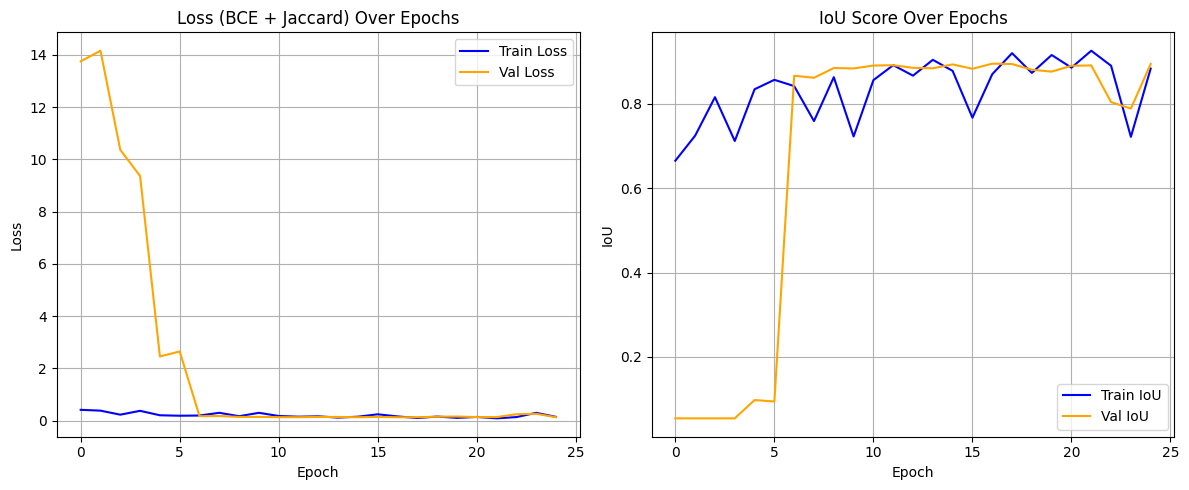

In [23]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss (BCE + Jaccard) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot IoU Score
plt.subplot(1, 2, 2)
plt.plot(history.history['iou_score'], label='Train IoU', color='blue')
plt.plot(history.history['val_iou_score'], label='Val IoU', color='orange')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


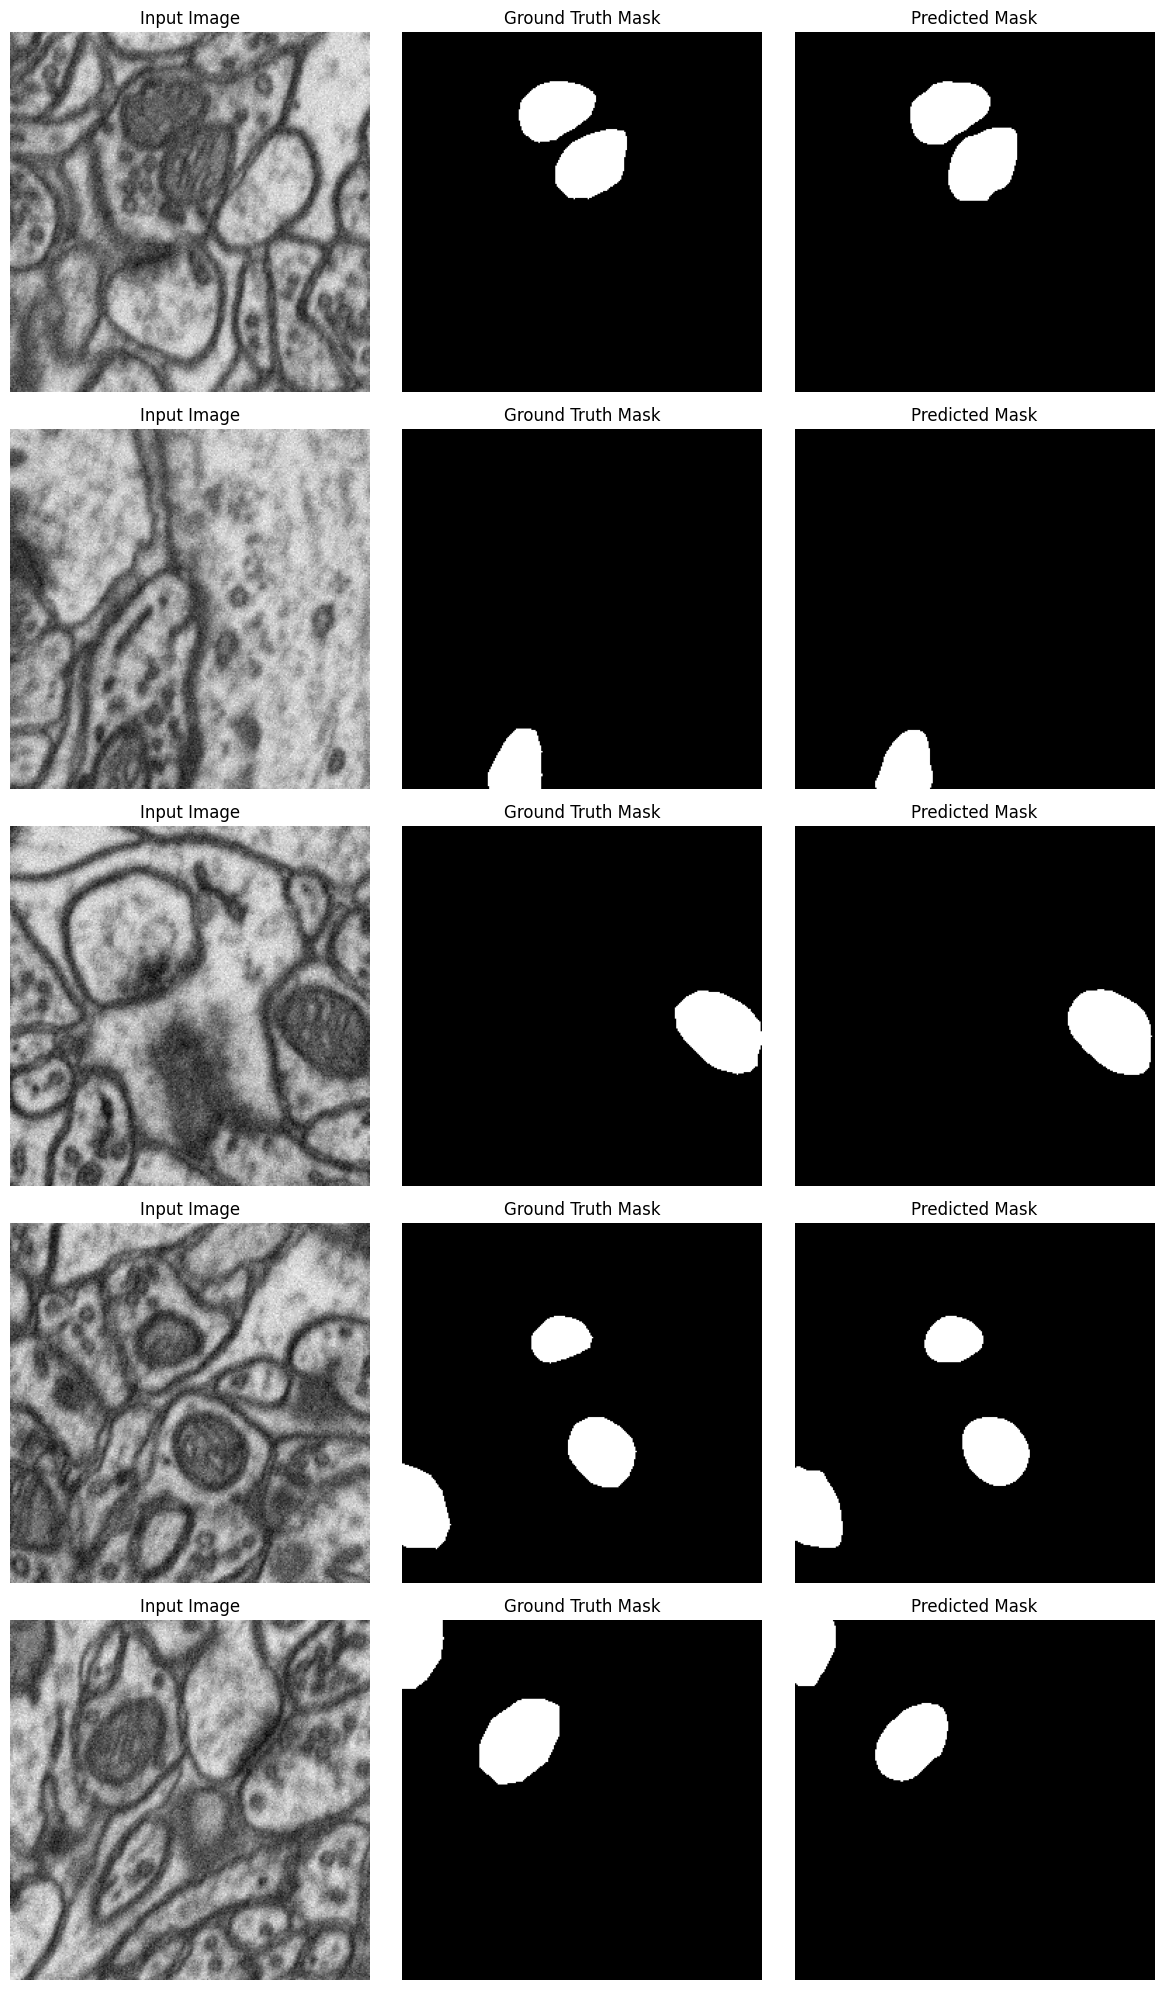

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, images, true_masks, num_samples=5):
    """
    Plots input image, ground truth mask, and predicted mask.

    Args:
        model: Trained segmentation model.
        images: np.ndarray of shape (N, H, W, 3)
        true_masks: np.ndarray of shape (N, H, W, 1) or (N, H, W)
        num_samples: Number of random samples to visualize
    """
    indices = np.random.choice(len(images), num_samples, replace=False)
    preds = model.predict(images[indices])

    plt.figure(figsize=(12, num_samples * 4))

    for i, idx in enumerate(indices):
        image = images[idx]
        true_mask = true_masks[idx]
        pred_mask = preds[i]

        # Reshape if necessary
        if true_mask.ndim == 3 and true_mask.shape[-1] == 1:
            true_mask = true_mask[..., 0]
        if pred_mask.shape[-1] == 1:
            pred_mask = pred_mask[..., 0]

        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

        # Image
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis('off')

        # Ground Truth
        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(pred_mask_bin, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_images_3ch, test_mask_patches, num_samples=5)

In [26]:
model.save('mitochondria_test.hdf5')